# Pose Estimation

In this notebook, we will create a yoga pose classifier. This take an input image and find the best match from the available yoga pose information we have. The classifier will extact the images key-point's and compare these to the labeled training dataset we have to identify the best match.

Current available yoga poses:
- Crescent Lunge
- Downward Dog
- Extended Triangle
- Warrior

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import warnings
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir
from os.path import join

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

import mediapipe as mp


from pose_estimation_utils import (get_bodypart_angle_df, estimate_line_vertex_angles, get_vertex_angles_dict, fit_knn_classifier,
                                   get_valid_pose_folder_names, generate_pose_landmarks)


from visualization_utils import read_and_display_image, plot_2d_pca_figure, custom_plot_landmarks_from_df

from math_utils import calc_angle_between_three_2d_points

from constants import mp_holistic, index_to_body_mapping

In [3]:
index_to_body_mapping

{0: 'nose',
 1: 'left_eye_inner',
 2: 'left_eye',
 3: 'left_eye_outer',
 4: 'right_eye_inner',
 5: 'right_eye',
 6: 'right_eye_outer',
 7: 'left_ear',
 8: 'right_ear',
 9: 'mouth_left',
 10: 'mouth_right',
 11: 'left_shoulder',
 12: 'right_shoulder',
 13: 'left_elbow',
 14: 'right_elbow',
 15: 'left_wrist',
 16: 'right_wrist',
 17: 'left_pinky',
 18: 'right_pinky',
 19: 'left_index',
 20: 'right_index',
 21: 'left_thumb',
 22: 'right_thumb',
 23: 'left_hip',
 24: 'right_hip',
 25: 'left_knee',
 26: 'right_knee',
 27: 'left_ankle',
 28: 'right_ankle',
 29: 'left_heel',
 30: 'right_heel',
 31: 'left_foot_index',
 32: 'right_foot_index'}

## Training Data setup

In [4]:
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")

create_new_pose_classification_df = False

if create_new_pose_classification_df:
    pose_classification_df = create_pose_classification_df(folder_dir)
    pose_classification_df.to_csv(csv_folder_dir, index=False)
else:
    pose_classification_df = pd.read_csv(csv_folder_dir)

pose_classification_df.head()

,image_path,pose_type
0,inputs/yoga_poses/pose_crescent_lunge/3.jpg,crescent_lunge
1,inputs/yoga_poses/pose_crescent_lunge/1.jpg,crescent_lunge
2,inputs/yoga_poses/pose_crescent_lunge/2.jpg,crescent_lunge
3,inputs/yoga_poses/pose_camel/3.jpg,camel
4,inputs/yoga_poses/pose_camel/1.jpeg,camel


#### Run if we want to add new yoga pose data to the training set

In [5]:
create_new_csvs= False

if create_new_csvs:
    with mp_holistic.Holistic(
        static_image_mode=True, min_detection_confidence=0.75, model_complexity=2, 
    ) as pose:
        for i_row, df in pose_classification_df.iterrows():
            image_path = df["image_path"]        
            pose_dir = os.path.dirname(image_path)
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            results = pose.process(image)

            landmark_body_arr = []
            for i, landmark in enumerate(results.pose_world_landmarks.landmark):
                body_part = index_to_body_mapping[i]
                landmark_body_arr.append([body_part, landmark.x, landmark.y, landmark.z, landmark.visibility])

            columns = ["pose_landmark", "x", "y", "z", "visibility"]
            landmark_pose_df = pd.DataFrame(data=landmark_body_arr, columns=columns)
            landmark_pose_df.to_csv(os.path.join(pose_dir, f"{base_name}_landmarks_holistic_0-75_2.csv"), index=False)    


## KNN pose classification

In [6]:
# Load in DF of all yoga images
folder_dir = "inputs/yoga_poses/"
csv_folder_dir = os.path.join(folder_dir, "pose_classification.csv")
pose_classification_df = pd.read_csv(csv_folder_dir)

# Get All pose names
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)
available_pose_names

['pose_crescent_lunge',
 'pose_warrior',
 'pose_extended_triangle',
 'pose_downwards_dog']

In [7]:
# Turn warnings off
warnings.filterwarnings("ignore", category=FutureWarning)

all_pose_frames = []

for pose_name in available_pose_names:
    single_pose_folder = os.path.join(base_pose_dir, pose_name)
    single_pose_files = os.listdir(single_pose_folder)

    for file in single_pose_files:
        if not ".csv" in file:
            continue

        curr_landmarks_df = pd.read_csv(os.path.join(single_pose_folder, file))        
        angles_df = get_bodypart_angle_df(curr_landmarks_df)
        angles_df["pose_type"] = pose_name
        all_pose_frames.append(angles_df)
        

# Turn warnings back on
warnings.filterwarnings("default", category=FutureWarning)

# Append all rows
all_poses_df = pd.concat(all_pose_frames).reset_index(drop=True)
print(f"all_poses_df: {all_poses_df.shape}")
all_poses_df.head()

all_poses_df: (14, 13)


,Left_armpit_angle,Right_armpit_angle,Left_shoulder_angle,Right_shoulder_angle,Left_elbow_angle,Right_elbow_angle,Left_hip_angle,Right_hip_angle,Left_groin_angle,Right_groin_angle,Left_knee_angle,Right_knee_angle,pose_type
0,12.541643,31.524616,59.995025,79.211543,12.448444,31.330298,70.083624,69.074423,112.391802,147.00458,31.67801,14.227233,pose_crescent_lunge
1,11.888171,30.424295,56.948161,76.784975,12.181707,31.227774,68.149518,65.574851,118.629668,148.329243,28.354241,14.032672,pose_crescent_lunge
2,4.068433,6.20493,59.305609,71.45006,17.541802,13.544875,60.515999,73.107563,153.133218,110.072427,13.077177,28.743207,pose_crescent_lunge
3,55.508006,78.223897,60.639146,64.600228,3.315841,13.812747,64.488344,61.796008,159.078252,109.136184,10.377522,28.954885,pose_warrior
4,57.265116,76.695563,55.267135,71.959579,3.513063,11.374307,61.743981,66.082676,93.786843,139.22874,40.376717,15.047133,pose_warrior


### Fit a PCA object followed by a KNN

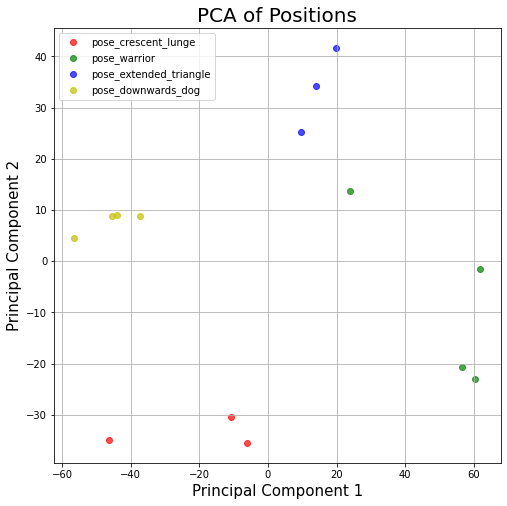

,principal component 1,principal component 2,pose_type
0,-6.111694,-35.530695,pose_crescent_lunge
1,-10.791353,-30.380811,pose_crescent_lunge
2,-46.160407,-35.025082,pose_crescent_lunge
3,24.042918,13.749582,pose_warrior
4,60.353571,-22.933535,pose_warrior


In [8]:
# Create training PCA data frame
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(all_poses_df.drop(columns="pose_type"))
pca_pose_df = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])
pca_pose_df = pd.concat([pca_pose_df, all_poses_df[["pose_type"]]], axis = 1)

plot_2d_pca_figure(pca_pose_df)
pca_pose_df.head()

Pose pose_downwards_dog


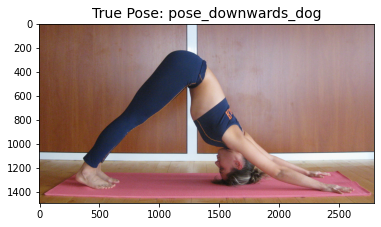

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


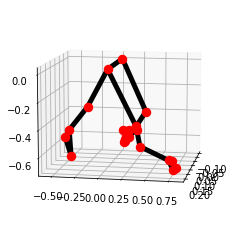

/home/ryan/Documents/projects/pose-estimation/pose_estimation_utils.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


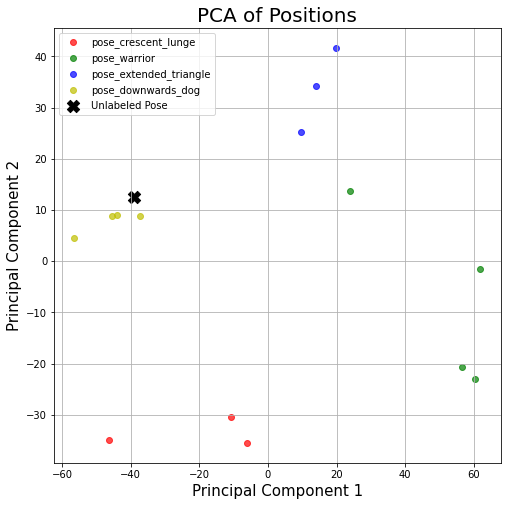

True Pose: pose_downwards_dog
KNN Predicted Pose ['pose_downwards_dog']

Pose pose_warrior


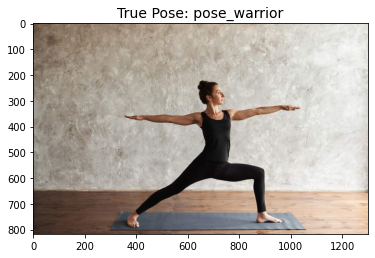

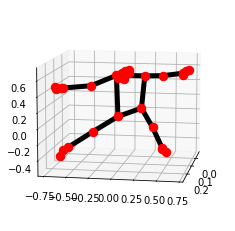

/home/ryan/Documents/projects/pose-estimation/pose_estimation_utils.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


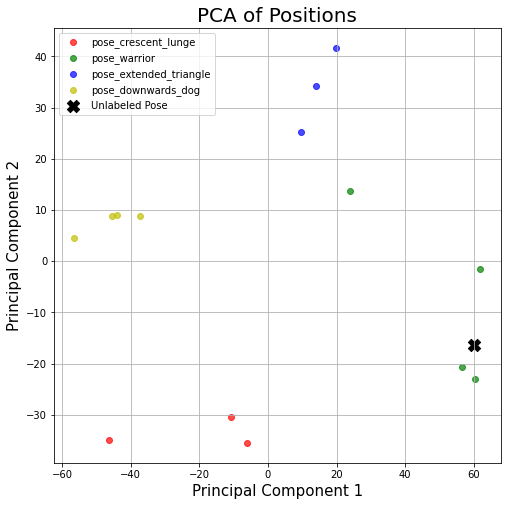

True Pose: pose_warrior
KNN Predicted Pose ['pose_warrior']

Pose pose_extended_triangle


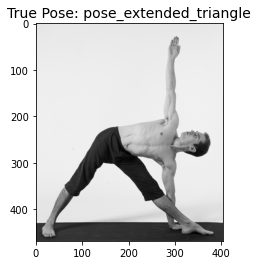

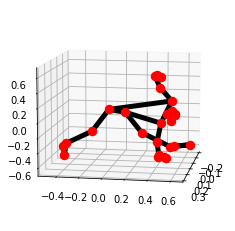

/home/ryan/Documents/projects/pose-estimation/pose_estimation_utils.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


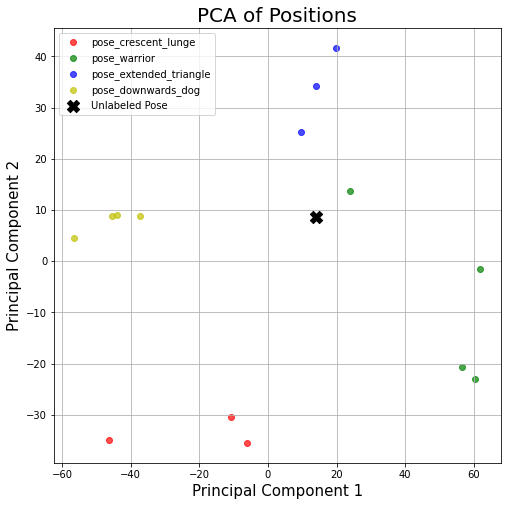

True Pose: pose_extended_triangle
KNN Predicted Pose ['pose_extended_triangle']

Pose pose_crescent_lunge


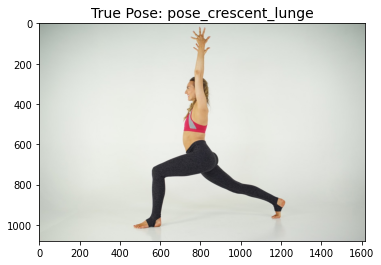

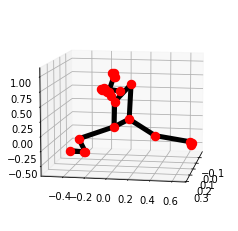

/home/ryan/Documents/projects/pose-estimation/pose_estimation_utils.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(angles_dict, ignore_index=True)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


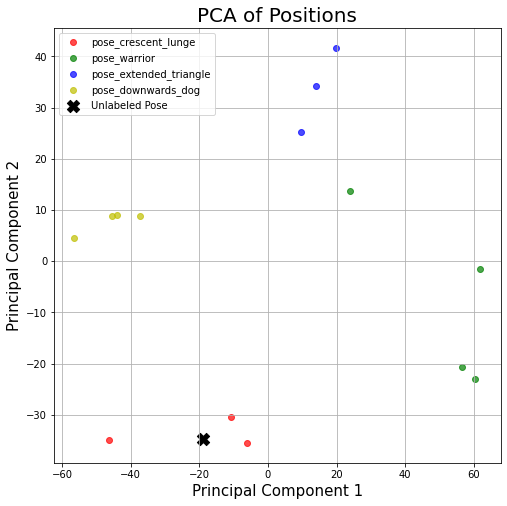

True Pose: pose_crescent_lunge
KNN Predicted Pose ['pose_crescent_lunge']



In [9]:
# Fit knn classifier
knn_classifier = fit_knn_classifier(df=pca_pose_df)


# Iterate through Test batch now
base_pose_dir = "inputs/yoga_poses/"
available_pose_names = get_valid_pose_folder_names(folder_dir)

input_imgs = ["downward_facing_dog.JPG", "warrior.jpg", "extended_triangle.png", "crescent_lunge.jpg"]
input_img_paths = [os.path.join("inputs/yoga_poses/test_poses/", f) for f in input_imgs]

true_poses = ["pose_downwards_dog", "pose_warrior", "pose_extended_triangle", "pose_crescent_lunge"]


for input_image_path, true_pose in zip(input_img_paths, true_poses):
    print(f"Pose {true_pose}")
    # Read in image
    input_img = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
    
    # Plot actual image and predicted vs true pose
    fig, ax_1 = plt.subplots()
    title = f"True Pose: {true_pose}"
    plt.title(title, fontsize=14)
    plt.imshow(input_img)
    plt.show()

    
    # Get landmarks df
    landmarks_df = generate_pose_landmarks(input_img)
    
    # Plot generated landmarks
    custom_plot_landmarks_from_df(landmarks_df)
    plt.show()
    
    # Predict Label
    pca_landmarks_df = pca.transform(get_bodypart_angle_df(landmarks_df))
    predicted_pca_knn_label = knn_classifier.predict(pca_landmarks_df)
    
    # Plot PCA yoga pose seperation with new transformed point
    ax = plot_2d_pca_figure(pca_pose_df, point_to_add=(pca_landmarks_df.flatten()))
    
    print(f"True Pose: {true_pose}\nKNN Predicted Pose {predicted_pca_knn_label}")
    print()

# Results

The classifer has 100% accuracy. In each instance we get a clearly distiguistable point on the PCA plot.

## Improvements
- Add more yoga poses to the training dataset